Testing FIBSEM Microscope overall class
    - Testing Thermo Fisher instance of class
    

Importing Relevant Modules

In [1]:
%load_ext autoreload
%autoreload 2

import fibsem
from fibsem import utils, acquire
import fibsem.alignment as fa
from fibsem.structures import BeamType, ImageSettings, GammaSettings, FibsemRectangle, FibsemImage, check_data_format, Point
import matplotlib.pyplot as plt
from fibsem import FibsemMicroscope, calibration
import os
import logging
from fibsem.utils import current_timestamp, configure_logging
from pathlib import Path
from autoscript_sdb_microscope_client.structures import (
    AdornedImage,
    GrabFrameSettings,
    Rectangle,
    RunAutoCbSettings,
)

Importing settings from config

In [2]:
settings = utils.load_settings_from_config()


Testing Setup 

In [3]:
microscope, settings = utils.setup_session()


2022-12-15 13:35:45,574 — root — INFO — setup_session:160 — Finished setup for session: demo_2022-12-15-01-35-45PM


In [7]:
print(microscope.connection.SEM.Beam.GetStatus())


params = microscope.connection.FIB.Optics.EnumParameters()

params = microscope.connection.FIB.Optics.EnumParameters()
split_params = params.split("\n")
for i, word in enumerate(split_params):
    if "Working Distance" in word:
        idx = int(word.split(".")[1])
        count = int(split_params[i+1].split("=")[-1]) - 1
        unit = split_params[i+2].split("=")[-1]
wd_ion = microscope.connection.FIB.Optics.Get(idx)[count]

print(wd_ion)

microscope.connection.FIB.Optics.SetWD(0)


HVBeamStatus.BeamOn
12.0


AttributeError: 'Optics' object has no attribute 'SetWD'

Setting up for image acquisition

In [14]:
print(settings)


MicroscopeSettings(system=SystemSettings(ip_address='localhost', application_file='autolamella', stage=StageSettings(rotation_flat_to_electron=49, rotation_flat_to_ion=229, tilt_flat_to_electron=35, tilt_flat_to_ion=52, pre_tilt=35, needle_stage_height_limit=0.0037), ion=BeamSystemSettings(beam_type=<BeamType.ION: 2>, voltage=30000, current=2e-11, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.0165, plasma_gas='Argon'), electron=BeamSystemSettings(beam_type=<BeamType.ELECTRON: 1>, voltage=2000, current=1e-12, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.00391, plasma_gas='Null'), manufacturer='Tescan'), image=ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, pixel_size=Point(x=0.0, y=0.0), autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=False, label='default_image', gamma=GammaSettings(enabled=True, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='c:\\Users\\lnae0002\\Des

Autoconcrast

In [15]:
microscope.autocontrast(beam_type=BeamType.ELECTRON)
microscope.autocontrast(beam_type=BeamType.ION)


Take new SEM image

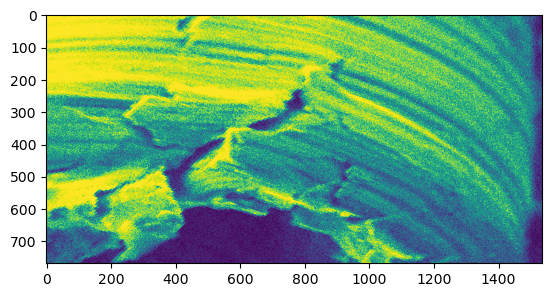

0.0003072
Point(x=2e-07, y=2e-07)
1536x1024
MicroscopeState(timestamp=1670885963.414222, absolute_position=FibsemStagePosition(x=7.2703e-05, y=0.0105, z=0.006559854, r=149.9454339, t=54.4, coordinate_system='Raw'), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.005970625, beam_current=1e-11, hfw=None, resolution='1536x1024', dwell_time=0.0, stigmation=Point(x=0.0, y=0.0), shift=Point(x=-0.0, y=-0.0)), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=None, beam_current=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None))


In [16]:
# set gamma settings
gamma_settings = GammaSettings(
    enabled=True,
    min_gamma=0.5,
    max_gamma=1.8,
    scale_factor=0.01,
    threshold=46,
)

pixel = Point(x=2e-07, y=2e-07)

# set imaging settings
image_settings = ImageSettings(
    resolution="1536x1024",
    dwell_time=1.0e-6,
    hfw=150.0e-6,
    pixel_size=pixel,
    autocontrast=True,
    beam_type=BeamType.ELECTRON,
    gamma=gamma_settings,
    save=True,
    save_path="fibsem\\test_images",
    label=utils.current_timestamp(),
    reduced_area=None,
)

new_image = acquire.new_image(microscope, image_settings)

plt.imshow(new_image.data)
plt.show()

print(new_image.metadata.image_settings.hfw)
print(new_image.metadata.pixel_size)
print(new_image.metadata.image_settings.resolution)

assert new_image.metadata.image_settings.hfw == (image_settings.pixel_size.x * 1536)
assert new_image.metadata.pixel_size == image_settings.pixel_size
assert isinstance(new_image, FibsemImage)
assert check_data_format(new_image.data)

assert new_image.metadata.compare_image_settings(image_settings)
assert new_image.metadata.version == "v1"
assert os.path.exists(
    f"{os.path.join(image_settings.save_path, image_settings.label)}_eb.tif"
)
# assert new_image.metadata.microscope_state.absolute_position == microscope.get_stage_position()

print(new_image.metadata.microscope_state)


Take new FIB image

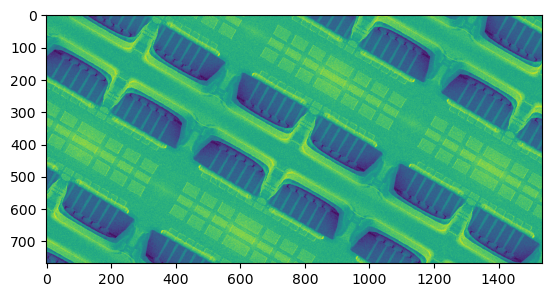

0.0003072
Point(x=2e-07, y=2e-07)
1536x1024
MicroscopeState(timestamp=1670885981.032346, absolute_position=FibsemStagePosition(x=7.2703e-05, y=0.0105, z=0.006559854, r=149.9454339, t=54.4, coordinate_system='Raw'), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=None, beam_current=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.012, beam_current=6e-15, hfw=None, resolution='1536x1024', dwell_time=0.0, stigmation=Point(x=0.0, y=0.0), shift=Point(x=0.0, y=0.0)))


In [17]:
# set gamma settings
gamma_settings = GammaSettings(
    enabled=True,
    min_gamma=0.5,
    max_gamma=1.8,
    scale_factor=0.01,
    threshold=46,
)

pixel = Point(x=2e-07, y=2e-07)

# set imaging settings
image_settings = ImageSettings(
    resolution="1536x1024",
    dwell_time=1.0e-6,
    hfw=150.0e-6,
    pixel_size=pixel,
    autocontrast=True,
    beam_type=BeamType.ION,
    gamma=gamma_settings,
    save=True,
    save_path="fibsem\\test_images",
    label=utils.current_timestamp(),
    reduced_area=None,
)

new_image = acquire.new_image(microscope, image_settings)

plt.imshow(new_image.data)
plt.show()

print(new_image.metadata.image_settings.hfw)
print(new_image.metadata.pixel_size)
print(new_image.metadata.image_settings.resolution)

assert new_image.metadata.image_settings.hfw == (image_settings.pixel_size.x * 1536)
assert new_image.metadata.pixel_size == image_settings.pixel_size
assert isinstance(new_image, FibsemImage)
assert check_data_format(new_image.data)

assert new_image.metadata.compare_image_settings(image_settings)
assert new_image.metadata.version == "v1"
assert os.path.exists(
    f"{os.path.join(image_settings.save_path, image_settings.label)}_ib.tif"
)
# assert new_image.metadata.microscope_state.absolute_position == microscope.get_stage_position()

print(new_image.metadata.microscope_state)


Take last SEM image

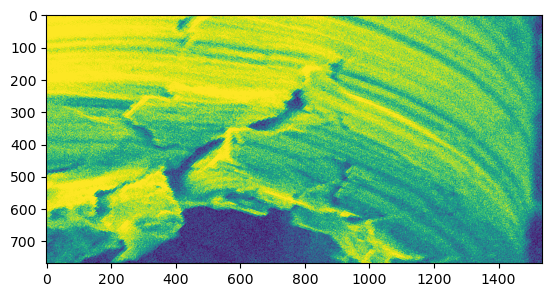

MicroscopeState(timestamp=1670885963.414222, absolute_position=FibsemStagePosition(x=7.2703e-05, y=0.0105, z=0.006559854, r=149.9454339, t=54.4, coordinate_system='Raw'), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.005970625, beam_current=1e-11, hfw=None, resolution='1536x1024', dwell_time=0.0, stigmation=Point(x=0.0, y=0.0), shift=Point(x=-0.0, y=-0.0)), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=None, beam_current=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None))


In [18]:
# set gamma settings
gamma_settings = GammaSettings(
    enabled=True,
    min_gamma=0.5,
    max_gamma=1.8,
    scale_factor=0.01,
    threshold=46,
)

pixel = Point(x=2e-07, y=2e-07)

# set imaging settings
image_settings = ImageSettings(
    resolution="1536x1024",
    dwell_time=1.0e-6,
    hfw=150.0e-6,
    pixel_size=pixel,
    autocontrast=True,
    beam_type=BeamType.ELECTRON,
    gamma=gamma_settings,
    save=True,
    save_path="fibsem\\test_images",
    label=utils.current_timestamp(),
    reduced_area=None,
)


label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    last_image.save(save_path=filename)

# assert isinstance(last_image, FibsemImage)
assert check_data_format(last_image.data)


# assert last_image.metadata.compare_image_settings(image_settings) # TODO: FIX THIS, different than img settings
assert last_image.metadata.version == "v1"
assert os.path.exists(f"{filename}.tif")

print(last_image.metadata.microscope_state)


Take last FIB image

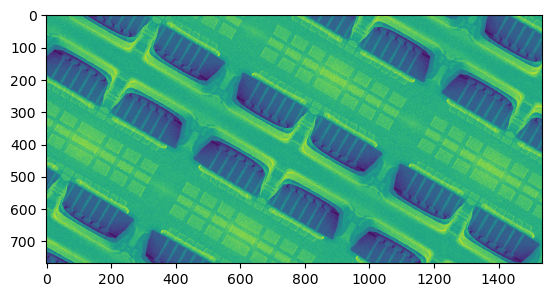

MicroscopeState(timestamp=1670885981.032346, absolute_position=FibsemStagePosition(x=7.2703e-05, y=0.0105, z=0.006559854, r=149.9454339, t=54.4, coordinate_system='Raw'), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=None, beam_current=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.012, beam_current=6e-15, hfw=None, resolution='1536x1024', dwell_time=0.0, stigmation=Point(x=0.0, y=0.0), shift=Point(x=0.0, y=0.0)))


In [19]:
# set gamma settings
gamma_settings = GammaSettings(
    enabled=True,
    min_gamma=0.5,
    max_gamma=1.8,
    scale_factor=0.01,
    threshold=46,
)

pixel = Point(x=2e-07, y=2e-07)

# set imaging settings
image_settings = ImageSettings(
    resolution="1536x1024",
    dwell_time=1.0e-6,
    hfw=150.0e-6,
    pixel_size=pixel,
    autocontrast=True,
    beam_type=BeamType.ION,
    gamma=gamma_settings,
    save=True,
    save_path="fibsem\\test_images",
    label=utils.current_timestamp(),
    reduced_area=None,
)


label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    last_image.save(save_path=filename)

# assert isinstance(last_image, FibsemImage)
assert check_data_format(last_image.data)

# assert last_image.metadata.compare_image_settings(image_settings) # TODO: FIX THIS, different than img settings
assert last_image.metadata.version == "v1"
assert os.path.exists(f"{filename}.tif")

print(last_image.metadata.microscope_state)


Take reference images

ReferenceImages(low_res_eb=<fibsem.structures.FibsemImage object at 0x000001F831DBD520>, high_res_eb=<fibsem.structures.FibsemImage object at 0x000001F831DBD310>, low_res_ib=<fibsem.structures.FibsemImage object at 0x000001F8322060D0>, high_res_ib=<fibsem.structures.FibsemImage object at 0x000001F83238BC70>)


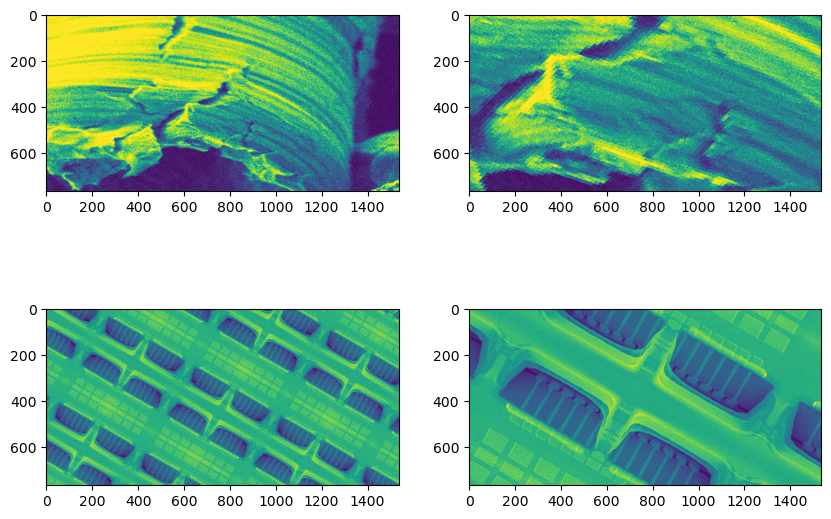

In [20]:
# set gamma settings
gamma_settings = GammaSettings(
    enabled=True,
    min_gamma=0.5,
    max_gamma=1.8,
    scale_factor=0.01,
    threshold=46,
)

pixel = Point(x=2e-07, y=2e-07)

# set imaging settings
image_settings = ImageSettings(
    resolution="1536x1024",
    dwell_time=1.0e-6,
    hfw=150.0e-6,
    pixel_size=None,
    autocontrast=True,
    beam_type=BeamType.ELECTRON,
    gamma=gamma_settings,
    save=True,
    save_path="fibsem\\test_images",
    label=utils.current_timestamp(),
    reduced_area=None,
)


# taking set of ref images
hfws = [400e-6, 150.0e-6]
ref_images = acquire.take_set_of_reference_images(microscope, image_settings, hfws)
fig = plt.figure(figsize=(10, 7))

print(ref_images)

fig.add_subplot(2, 2, 1)
plt.imshow(ref_images.low_res_eb.data)
fig.add_subplot(2, 2, 2)
plt.imshow(ref_images.high_res_eb.data)
fig.add_subplot(2, 2, 3)
plt.imshow(ref_images.low_res_ib.data)
fig.add_subplot(2, 2, 4)
plt.imshow(ref_images.high_res_ib.data)

# checking image data
# if ref_images.low_res_eb.metadata.compare_image_settings(image_settings):
#     print("Image settings are the same")
# print(ref_images[0].metadata.microscope_state.timestamp)
# print(ref_images[0].metadata.version)


assert (
    ref_images.low_res_eb.metadata.image_settings.hfw == hfws[0]
), f"hfw: {ref_images.low_res_eb.metadata.image_settings.hfw} != {hfws[0]}"
assert (
    ref_images.low_res_ib.metadata.image_settings.hfw == hfws[0]
), f"hfw: {ref_images.low_res_ib.metadata.image_settings.hfw} != {hfws[0]}"
assert (
    ref_images.high_res_eb.metadata.image_settings.hfw == hfws[1]
), f"hfw: {ref_images.high_res_eb.metadata.image_settings.hfw} != {hfws[1]}"
assert (
    ref_images.high_res_ib.metadata.image_settings.hfw == hfws[1]
), f"hfw: {ref_images.high_res_ib.metadata.image_settings.hfw} != {hfws[1]}"


Disconnect from Microscope

In [21]:
microscope.disconnect()
